In [3]:
import warnings
import tensorflow as tf
from tensorflow import keras
warnings.filterwarnings('ignore')

# !unzip "/content/drive/MyDrive/Academics/Final Year Project/Final Year Project Code/Train Videos.zip" -d "/content/Dataset/"

In [4]:
from keras import applications
#from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input


BATCH_SIZE_TRAINING = 100
IMAGE_RESIZE = (240, 320)

train_data_generator = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_data_generator.flow_from_directory(
    'C:/Users/berat/Desktop/CrimeCatch-master/2. Training Deep Learning Model/content/Dataset', 
    target_size=IMAGE_RESIZE, 
    batch_size=BATCH_SIZE_TRAINING, 
    class_mode='binary'
)

Found 29882 images belonging to 2 classes.


In [5]:
print(f'train_gen.class_indices: {train_generator.class_indices}')

train_gen.class_indices: {'0': 0, '1': 1}


In [6]:
division = {1:4034, 0:7379}
length = 11413

def balancedClassWeight(n_samples: int, n_samples_with_class: dict) -> dict:
    
    toRet = {}
    n_classes=len(n_samples_with_class.keys())
    
    keys = n_samples_with_class.keys()
    
    for item in keys:
        toRet[item] = (n_samples/(n_classes*n_samples_with_class[item]))
        
    return toRet

class_weight = balancedClassWeight(length, division)

print(f'class weights: {class_weight}')

class weights: {1: 1.4146008924144768, 0: 0.7733432714459954}


In [7]:
from keras.applications import ResNet50
from keras.layers import Input
from keras.layers import GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Model


baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(240, 320, 3)))
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)


for layer in baseModel.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 31s 0us/step


In [8]:
from keras import optimizers
adam = optimizers.Adam(lr=1e-4)
model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])


from tensorflow.python.keras.callbacks import EarlyStopping
cb_early_stopper = EarlyStopping(monitor = 'loss', patience = 4)

In [9]:
NUM_EPOCHS = 10
STEPS_PER_EPOCH_TRAINING = length//BATCH_SIZE_TRAINING

fit_history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
    class_weight=class_weight,
    epochs = NUM_EPOCHS,
    callbacks=[cb_early_stopper]
)

Epoch 1/10
114/114 [==============================] - 642s 6s/step - loss: 0.3751 - accuracy: 0.8321
Epoch 2/10
114/114 [==============================] - 625s 5s/step - loss: 0.2396 - accuracy: 0.9024
Epoch 3/10
114/114 [==============================] - 592s 5s/step - loss: 0.1935 - accuracy: 0.9197
Epoch 4/10
114/114 [==============================] - 569s 5s/step - loss: 0.1766 - accuracy: 0.9299
Epoch 5/10
114/114 [==============================] - 561s 5s/step - loss: 0.1704 - accuracy: 0.9290
Epoch 6/10
114/114 [==============================] - 547s 5s/step - loss: 0.1481 - accuracy: 0.9386
Epoch 7/10
114/114 [==============================] - 563s 5s/step - loss: 0.1534 - accuracy: 0.9357
Epoch 8/10
114/114 [==============================] - 590s 5s/step - loss: 0.1462 - accuracy: 0.9397
Epoch 9/10
114/114 [==============================] - 555s 5s/step - loss: 0.1382 - accuracy: 0.9445
Epoch 10/10
114/114 [==============================] - 526s 5s/step - loss: 0.1289 - accura

In [10]:
model_save_path = 'C:/Users/berat/Desktop/modelsave'
model.save(model_save_path)

INFO:tensorflow:Assets written to: C:/Users/berat/Desktop/modelsave\assets


INFO:tensorflow:Assets written to: C:/Users/berat/Desktop/modelsave\assets


In [11]:
print(fit_history.history.keys())

dict_keys(['loss', 'accuracy'])


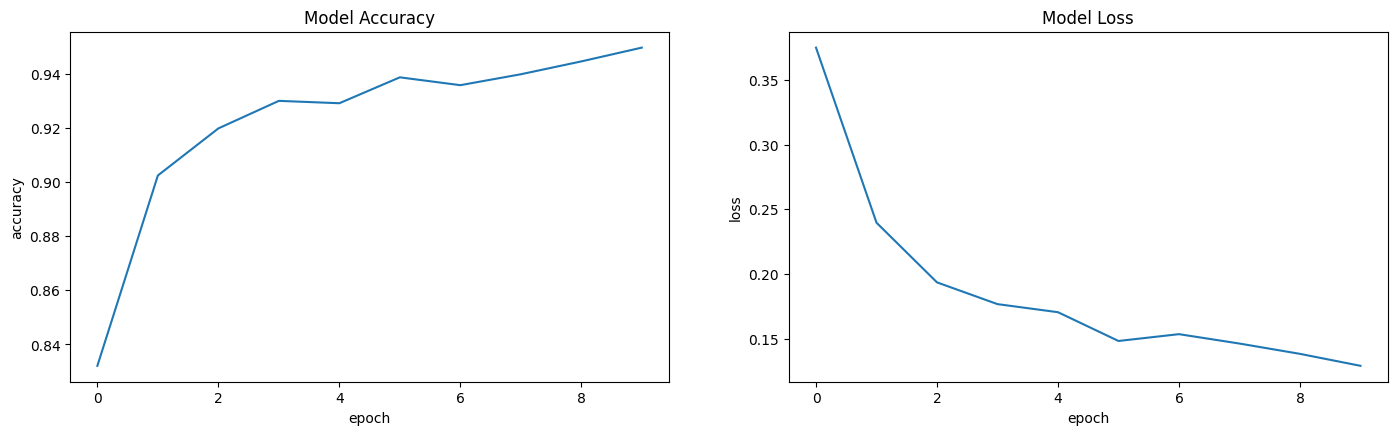

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize = (17,10)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])    
plt.title('Model Accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.title('Model Loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  

plt.show()